In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from google.colab import drive
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification
import os
import re
import torch

tqdm.pandas()

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Capstone_design/")

Mounted at /content/drive


# Load Data & Preprocessing

## Load Data & EDA

In [ ]:
train = pd.read_csv("SBIC.v2.agg.trn.csv")
val = pd.read_csv("SBIC.v2.agg.dev.csv")
test = pd.read_csv("SBIC.v2.agg.tst.csv")

In [ ]:
print("Size of train set : {}".format(len(train)))
print("Size of validation set : {}".format(len(val)))
print("Size of test set : {}".format(len(test)))

Size of train set : 35424
Size of validation set : 4666
Size of test set : 4691


## Proprocess

In [ ]:
def clean_text(text):
  # Remove @RT
  text = re.sub("RT @[\S]+", "", text)
  # Remove mention @~
  text = re.sub("@[\S]+", "", text)
  # Remove &#~
  text = re.sub("&#[\S]+", "", text)
  # remove URL
  url = re.compile(r'https?://\S+|www\.\S+')
  text = url.sub(r'',text)
  # remove HTML
  html=re.compile(r'<.*?>')
  text = html.sub(r'',text)
  # remove emoji
  emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  # remove punctuation except 
  text = re.sub(r"[^\w\d'\s]+",'',text)
  # replace \n to ' '
  text = re.sub(r"\n+",' ',text).strip()

  return text

In [ ]:
def preprocess(data):
  # Avoid data sharing
  df = data.copy()
  # clean text in post column
  df["post"] = df["post"].apply(lambda x : clean_text(x))
  # Just use offensiveYN, post
  df = df[["offensiveYN", "post"]]
  # label 1 if offensiveYN > 0.5 else 0
  df["offensiveYN"] = df["offensiveYN"].apply(lambda x : 1 if x >= 0.5 else 0)

  return df

In [ ]:
# Preprocess train, val, test data
train_cleaned = preprocess(train)
eval_cleaned = preprocess(val)
test_cleaned = preprocess(test)

# Cartography

## Tokenizer & Model

In [ ]:
# gpu device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Get pretrained tokenzier and model(for binary classification)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Configuration for training

In [ ]:
import glob
import logging
import numpy as np
import os
import random
import shutil
import torch
import json

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from torch.utils.data.distributed import DistributedSampler
from transformers.data.metrics import acc_and_f1
from tqdm import tqdm, trange
from collections import defaultdict
from typing import List
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    get_linear_schedule_with_warmup
)


from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger(__name__)

In [ ]:
class TrainArgs():
  def __init__(self, seed, output_dir, learning_rate, num_train_epochs):

    ### Required parameters

    # Input data
    # self.train : str = configs.get("train", None)
    # self.dev : str = configs.get("dev", None)
    # self.test: str = configs.get("test", None)

    # Random seed for initialization.
    self.seed = seed

    # The output directory where the model predictions and checkpoints will be written.
    self.output_dir = output_dir

    # Whether to run training.
    # self.do_train : bool = configs.get("do_train", False)

    # # Whether to run eval on the dev set.
    # self.do_eval : bool = configs.get("do_eval", False)

    # # Whether to run eval on the dev set.
    # self.do_test : bool = configs.get("do_test", False)

    ### Other parameters

    # Where to store the feature cache for the model.
    self.features_cache_dir = "./feature_cache{}/".format(seed)

    # The maximum total input sequence length after tokenization.
    # Sequences longer than this will be truncated,
    # sequences shorter will be padded.
    self.max_seq_length = 128

    # Run evaluation during training after each epoch.
    self.evaluate_during_training = True

    # Run evaluation during training at each logging step.
    self.evaluate_during_training_epoch =  False

    # Set this flag if you are using an uncased model.
    self.do_lower_case = True

    # Batch size per GPU/CPU for training.
    self.per_gpu_train_batch_size = 96

    # Batch size per GPU/CPU for evaluation.
    self.per_gpu_eval_batch_size = 96

    # Number of updates steps to accumulate before
    # performing a backward/update pass.
    self.gradient_accumulation_steps = 1

    # The initial learning rate for Adam.
    self.learning_rate = learning_rate

    # Weight decay if we apply some.
    self.weight_decay = 0.0

    # Epsilon for Adam optimizer.
    self.adam_epsilon = 1e-8

    # Max gradient norm.
    self.max_grad_norm = 1.0

    # Total number of training epochs to perform.
    self.num_train_epochs = num_train_epochs

    # If > 0 : set total number of training steps to perform.
    # Override num_train_epochs.
    self.max_steps = -1

    # Linear warmup over warmup_steps.
    self.warmup_steps = 0

    # Log every X updates steps.
    self.logging_steps = 1000

    # If dev performance does not improve in X updates, end training.
    self.patience = 3

    # Save checkpoint every X updates steps.
    self.save_steps = 0

    # Evaluate all checkpoints starting with the same prefix as
    # model_name ending and ending with step number
    self.eval_all_checkpoints = False

    # Avoid using CUDA when available
    self.no_cuda = False

    # Overwrite the content of the output directory
    self.overwrite_output_dir = False

    # Overwrite the cached training and evaluation sets
    self.overwrite_cache = False

    # Whether to use 16-bit (mixed) precision (through NVIDIA apex)
    # instead of 32-bit
    self.fp16 = False

    # For fp16 : Apex AMP optimization level selected in
    # ['O0', 'O1', 'O2', and 'O3'].
    # See details at https://nvidia.github.io/apex/amp.html"
    self.fp16_opt_level = "01"

    # For distributed training.
    self.local_rank = -1

    # For distant debugging.
    self.server_ip =  ""
    self.server_port = ""

    # number of gpu
    self.n_gpu = torch.cuda.device_count()

## Train

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, index):
        input_ids = self.tokens["input_ids"][index]
        token_type_ids = self.tokens["token_type_ids"][index]
        attention_mask = self.tokens["attention_mask"][index]
        label = self.labels[index]

        return input_ids, token_type_ids, attention_mask, label, index
    
    def __len__(self):
        return len(self.labels)

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def evaluate(args, model, tokenizer, prefix="", eval_split="dev"):
    # We do not really need a loop to handle MNLI double evaluation (matched, mis-matched).

    eval_output_dir = args.output_dir

    results = {}
    eval_tokenized = tokenizer(eval_cleaned["post"].values.tolist(), 
                                padding=True, truncation=True, max_length=args.max_seq_length, return_tensors="pt")
    eval_dataset = CustomDataset(eval_tokenized, eval_cleaned["offensiveYN"])
    if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
      os.makedirs(eval_output_dir)

    eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)

    # multi-gpu eval
    if args.n_gpu > 1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info(f"***** Running {prefix} evaluation on {eval_split} *****")
    logger.info(f"  Num examples = {len(eval_dataset)}")
    logger.info(f"  Batch size = {eval_batch_size}")
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    example_ids = []
    gold_labels = []

    for batch in tqdm(eval_dataloader, desc="Evaluating", mininterval=10, ncols=100):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1],"token_type_ids": batch[2], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
            example_ids += batch[4].tolist()
            gold_labels += batch[3].tolist()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    probs = torch.nn.functional.softmax(torch.Tensor(preds), dim=-1)
    max_confidences = (torch.max(probs, dim=-1)[0]).tolist()
    preds = np.argmax(preds, axis=1)  # Max of logit is the same as max of probability.

    result = acc_and_f1(preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(
        eval_output_dir, f"eval_metrics_{eval_split}_{prefix}.json")
    logger.info(f"***** {eval_split} results {prefix} *****")
    for key in sorted(result.keys()):
        logger.info(f"{eval_split} {prefix} {key} = {result[key]:.4f}")
    with open(output_eval_file, "a") as writer:
        writer.write(json.dumps(results) + "\n")

    # predictions
    all_predictions = []
    output_pred_file = os.path.join(
        eval_output_dir, f"predictions_{eval_split}_{prefix}.lst")
    with open(output_pred_file, "w") as writer:
        logger.info(f"***** Write {eval_split} predictions {prefix} *****")
        for ex_id, pred, gold, max_conf, prob in zip(
            example_ids, preds, gold_labels, max_confidences, probs.tolist()):
            record = {"guid": int(ex_id),
                      "label": int(pred),
                      "gold": int(gold),
                      "confidence": int(max_conf),
                      "probabilities": prob}
            all_predictions.append(record)
            writer.write(json.dumps(record) + "\n")

    return results, all_predictions


In [ ]:
def save_model(args, model, tokenizer, epoch, best_epoch,  best_dev_performance):
    results, _ = evaluate(args, model, tokenizer, prefix="in_training")
    # TODO(SS): change hard coding `acc` as the desired metric, might not work for all tasks.
    desired_metric = "acc"
    dev_performance = results.get(desired_metric)
    if dev_performance > best_dev_performance:
        best_epoch = epoch
        best_dev_performance = dev_performance

        # Save model checkpoint
        # Take care of distributed/parallel training
        model_to_save = (model.module if hasattr(model, "module") else model)
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        logger.info(f"*** Found BEST model, and saved checkpoint. "
            f"BEST dev performance : {dev_performance:.4f} ***")
    return best_dev_performance, best_epoch

In [ ]:
logging.basicConfig(
  format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)

In [ ]:
def log_training_dynamics(output_dir: os.path,
                          epoch: int,
                          train_ids: List[int],
                          train_logits: List[List[float]],
                          train_golds: List[int]):
  """
  Save training dynamics (logits) from given epoch as records of a `.jsonl` file.
  """
  td_df = pd.DataFrame({"guid": train_ids,
                        f"logits_epoch_{epoch}": train_logits,
                        "gold": train_golds})

  logging_dir = os.path.join(output_dir, f"training_dynamics")
  # Create directory for logging training dynamics, if it doesn't already exist.
  if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)
  epoch_file_name = os.path.join(logging_dir, f"dynamics_epoch_{epoch}.jsonl")
  td_df.to_json(epoch_file_name, lines=True, orient="records")
  logger.info(f"Training Dynamics logged to {epoch_file_name}")


In [ ]:
def train(args, train_dataset, model, tokenizer):
  """ Train the model """
  if args.local_rank in [-1, 0]:
      tb_writer = SummaryWriter()

  train_sampler = RandomSampler(
      train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
  train_dataloader = DataLoader(
      train_dataset, sampler=train_sampler, batch_size=train_batch_size)
  if args.max_steps > 0:
      t_total = args.max_steps
      args.num_train_epochs = args.max_steps // (
          len(train_dataloader) // args.gradient_accumulation_steps) + 1
  else:
      t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": args.weight_decay,
        },
      {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
        },
  ]

  optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
  )

  # Train!
  logger.info("***** Running training *****")
  logger.info("  Num examples = %d", len(train_dataset))
  logger.info("  Num Epochs = %d", num_train_epochs)
  logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
  logger.info(
      "  Total train batch size (w. parallel, distributed & accumulation) = %d",
      train_batch_size
      * args.gradient_accumulation_steps
      * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
  )
  logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
  logger.info("  Total optimization steps = %d", t_total)

  global_step = 0
  epochs_trained = 0
  steps_trained_in_this_epoch = 0

  tr_loss, logging_loss, epoch_loss = 0.0, 0.0, 0.0
  model.zero_grad()
  train_iterator = trange(epochs_trained,
                          int(num_train_epochs),
                          desc="Epoch",
                          disable=args.local_rank not in [-1, 0],
                          mininterval=10,
                          ncols=100)
  set_seed(args)  # Added here for reproductibility
  best_dev_performance = 0
  best_epoch = epochs_trained

  train_acc = 0.0
  for epoch, _ in enumerate(train_iterator):
      epoch_iterator = tqdm(train_dataloader,
                            desc="Iteration",
                            disable=args.local_rank not in [-1, 0],
                            mininterval=10,
                            ncols=100)

      train_iterator.set_description(f"train_epoch: {epoch} train_acc: {train_acc:.4f}")
      train_ids = None
      train_golds = None
      train_logits = None
      train_losses = None
      for step, batch in enumerate(epoch_iterator):
          # Skip past any already trained steps if resuming training
          if steps_trained_in_this_epoch > 0:
              steps_trained_in_this_epoch -= 1
              continue

          model.train()
          batch = tuple(t.to(device) for t in batch)
          inputs = {"input_ids": batch[0], "attention_mask": batch[1],"token_type_ids": batch[2], "labels": batch[3]}
          outputs = model(**inputs)
          loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

          if train_logits is None:  # Keep track of training dynamics.
              train_ids = batch[4].detach().cpu().numpy()
              train_logits = outputs[1].detach().cpu().numpy()
              train_golds = inputs["labels"].detach().cpu().numpy()
              train_losses = loss.detach().cpu().numpy()
          else:
              train_ids = np.append(train_ids, batch[4].detach().cpu().numpy())
              train_logits = np.append(train_logits, outputs[1].detach().cpu().numpy(), axis=0)
              train_golds = np.append(train_golds, inputs["labels"].detach().cpu().numpy())
              train_losses = np.append(train_losses, loss.detach().cpu().numpy())

          if args.n_gpu > 1:
              loss = loss.mean()  # mean() to average on multi-gpu parallel training
          if args.gradient_accumulation_steps > 1:
              loss = loss / args.gradient_accumulation_steps

          loss.backward()

          tr_loss += loss.item()
          if (step + 1) % args.gradient_accumulation_steps == 0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

              optimizer.step()
              scheduler.step()  # Update learning rate schedule
              model.zero_grad()
              global_step += 1

              if (
                  args.local_rank in [-1, 0] and
                  args.logging_steps > 0 and
                  global_step % args.logging_steps == 0
              ):
                  epoch_log = {}
                  # Only evaluate when single GPU otherwise metrics may not average well
                  if args.local_rank == -1 and args.evaluate_during_training_epoch:
                      logger.info(f"From within the epoch at step {step}")
                      results, _ = evaluate(args, model, tokenizer)
                      for key, value in results.items():
                          eval_key = "eval_{}".format(key)
                          epoch_log[eval_key] = value

                  epoch_log["learning_rate"] = scheduler.get_lr()[0]
                  epoch_log["loss"] = (tr_loss - logging_loss) / args.logging_steps
                  logging_loss = tr_loss

                  for key, value in epoch_log.items():
                      tb_writer.add_scalar(key, value, global_step)
                  logger.info(json.dumps({**epoch_log, **{"step": global_step}}))

              if (
                  args.local_rank in [-1, 0] and
                  args.save_steps > 0 and
                  global_step % args.save_steps == 0
              ):
                  # Save model checkpoint
                  output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                  if not os.path.exists(output_dir):
                      os.makedirs(output_dir)
                  model_to_save = (
                      model.module if hasattr(model, "module") else model
                  )  # Take care of distributed/parallel training
                  model_to_save.save_pretrained(output_dir)
                  tokenizer.save_pretrained(output_dir)

                  logger.info("Saving model checkpoint to %s", output_dir)

                  torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                  torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                  logger.info("Saving optimizer and scheduler states to %s", output_dir)

          epoch_iterator.set_description(f"lr = {scheduler.get_lr()[0]:.8f}, "
                                          f"loss = {(tr_loss-epoch_loss)/(step+1):.4f}")
          if args.max_steps > 0 and global_step > args.max_steps:
              epoch_iterator.close()
              break

      #### Post epoch eval ####
      # Only evaluate when single GPU otherwise metrics may not average well
      if args.local_rank == -1 and args.evaluate_during_training:
          best_dev_performance, best_epoch = save_model(args,
              model, tokenizer, epoch, best_epoch, best_dev_performance)

      # Keep track of training dynamics.
      log_training_dynamics(output_dir=args.output_dir,
                            epoch=epoch,
                            train_ids=list(train_ids),
                            train_logits=list(train_logits),
                            train_golds=list(train_golds))
      train_result = acc_and_f1(np.argmax(train_logits, axis=1), train_golds)
      train_acc = train_result["acc"]

      epoch_log = {"epoch": epoch,
                    "train_acc": train_acc,
                    "best_dev_performance": best_dev_performance,
                    "avg_batch_loss": (tr_loss - epoch_loss) / args.per_gpu_train_batch_size,
                    "learning_rate": scheduler.get_lr()[0],}
      epoch_loss = tr_loss

      logger.info(f"  End of epoch : {epoch}")
      with open(os.path.join(args.output_dir, f"eval_metrics_train.json"), "a") as toutfile:
          toutfile.write(json.dumps(epoch_log) + "\n")
      for key, value in epoch_log.items():
          tb_writer.add_scalar(key, value, global_step)
          logger.info(f"  {key}: {value:.6f}")

      if args.max_steps > 0 and global_step > args.max_steps:
          train_iterator.close()
          break
      elif args.evaluate_during_training and epoch - best_epoch >= args.patience:
          logger.info(f"Ran out of patience. Best epoch was {best_epoch}. "
              f"Stopping training at epoch {epoch} out of {num_train_epochs} epochs.")
          train_iterator.close()
          break

  if args.local_rank in [-1, 0]:
      tb_writer.close()

  return global_step, tr_loss / global_step

In [ ]:
seed = 789 # 3 seed : 123, 777, 789
trial_time = "fourth"
output_dir = "./output_{}".format(trial_time)
learning_rate = 1e-5
num_train_epochs = 6
targs = TrainArgs(seed, output_dir, learning_rate, num_train_epochs)

In [ ]:
# Prepare train dataset
train_batch_size = targs.per_gpu_train_batch_size * max(1, targs.n_gpu)
train_tokenized = tokenizer(train_cleaned["post"].values.tolist(), 
                            padding=True, truncation=True, max_length=targs.max_seq_length, return_tensors="pt")
train_dataset = CustomDataset(train_tokenized, train_cleaned["offensiveYN"])

In [24]:
train(targs, train_dataset, model, tokenizer)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
train_epoch: 0 train_acc: 0.0000:   0%|                                       | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:257: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

lr = 0.00000833, loss = 0.6945: 100%|█████████████████████████████| 369/369 [02:48<00:00,  2.19it/s]

Evaluating: 100%|███████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.30it/s]
/usr/local/lib/python3.9/dist-packages/transformers/data/metrics/__init__.py:37: FutureWarning: This metric will be removed from the library s

(2214, 0.6594512990012078)

# Compute Training Dynamics & Plot Data Maps

In [28]:
class DynamicsArgs():
  def __init__(self, model_dir, plots_dir, filtering_output_dir, burn_out):
    self.filter = False
    self.plot = True
    self.model_dir = model_dir
    self.plots_dir = plots_dir
    self.include_ci = True
    self.filtering_output_dir = filtering_output_dir
    self.worst = False
    self.both_ends = False
    self.burn_out = burn_out
    self.model = "Bert_uncased"

args = {
'filter' : False,
'plot' : True,
'model_dir' : "./output/" , #Directory where model training dynamics stats reside / PATH_TO_MODEL_OUTPUT_DIR_WITH_TRAINING_DYNAMICS
'plots_dir' :"./plots/" , #Directory where plots are to be saved
'include_ci' : True , #Compute the confidence interval for variability
'filtering_output_dir': "./filtered/",  #Output directory where filtered datasets are to be written
'worst' : True, #Select from the opposite end of the spectrum acc. to metric,""
'both_ends' : True, #Select from both ends of the spectrum acc. to metric
'burn_out' : 30, # Epochs for which to compute train dynamics
'model' : "Bert_uncased" #Model for which data map is being plotted
}

In [29]:
model_dir = targs.output_dir
plots_dir = "./plots_{}/".format(trial_time)
filtering_output_dir = "./filtered/"
burn_out = 4
args = DynamicsArgs(model_dir, plots_dir, filtering_output_dir, burn_out)

In [30]:
print(model_dir)
print(plots_dir)

./output_fourth
./plots_fourth/


In [31]:
def read_training_dynamics(model_dir: os.path,
                           strip_last: bool = False,
                           id_field: str = "guid",
                           burn_out: int = None):
  """
  Given path to logged training dynamics, merge stats across epochs.
  Returns:
  - Dict between ID of a train instances and its gold label, and the list of logits across epochs.
  """
  train_dynamics = {}

  td_dir = os.path.join(model_dir, "training_dynamics")
  num_epochs = len([f for f in os.listdir(td_dir) if os.path.isfile(os.path.join(td_dir, f))])
  if burn_out:
    num_epochs = burn_out

  logger.info(f"Reading {num_epochs} files from {td_dir} ...")
  for epoch_num in tqdm(range(num_epochs)):
    epoch_file = os.path.join(td_dir, f"dynamics_epoch_{epoch_num}.jsonl")
    assert os.path.exists(epoch_file)

    with open(epoch_file, "r") as infile:
      for line in infile:
        record = json.loads(line.strip())
        guid = record[id_field] if not strip_last else record[id_field][:-1]
        if guid not in train_dynamics:
          assert epoch_num == 0
          train_dynamics[guid] = {"gold": record["gold"], "logits": []}
        train_dynamics[guid]["logits"].append(record[f"logits_epoch_{epoch_num}"])

  logger.info(f"Read training dynamics for {len(train_dynamics)} train instances.")
  return train_dynamics

In [32]:
def compute_correctness(trend: List[float]) -> float:
  """
  Aggregate #times an example is predicted correctly during all training epochs.
  """
  return sum(trend)

In [33]:
def compute_forgetfulness(correctness_trend: List[float]) -> int:
  """
  Given a epoch-wise trend of train predictions, compute frequency with which
  an example is forgotten, i.e. predicted incorrectly _after_ being predicted correctly.
  Based on: https://arxiv.org/abs/1812.05159
  """
  if not any(correctness_trend):  # Example is never predicted correctly, or learnt!
      return 1000
  learnt = False  # Predicted correctly in the current epoch.
  times_forgotten = 0
  for is_correct in correctness_trend:
    if (not learnt and not is_correct) or (learnt and is_correct):
      # nothing changed.
      continue
    elif learnt and not is_correct:
      # Forgot after learning at some point!
      learnt = False
      times_forgotten += 1
    elif not learnt and is_correct:
      # Learnt!
      learnt = True
  return times_forgotten

In [34]:
def compute_train_dy_metrics(training_dynamics, args):
  """
  Given the training dynamics (logits for each training instance across epochs), compute metrics
  based on it, for data map coorodinates.
  Computed metrics are: confidence, variability, correctness, forgetfulness, threshold_closeness---
  the last two being baselines from prior work
  (Example Forgetting: https://arxiv.org/abs/1812.05159 and
    Active Bias: https://arxiv.org/abs/1704.07433 respectively).
  Returns:
  - DataFrame with these metrics.
  - DataFrame with more typical training evaluation metrics, such as accuracy / loss.
  """
  confidence_ = {}
  variability_ = {}
  threshold_closeness_ = {}
  correctness_ = {}
  forgetfulness_ = {}

  # Functions to be applied to the data.
  variability_func = lambda conf: np.std(conf)
  if args.include_ci:  # Based on prior work on active bias (https://arxiv.org/abs/1704.07433)
    variability_func = lambda conf: np.sqrt(np.var(conf) + np.var(conf) * np.var(conf) / (len(conf)-1))
  threshold_closeness_func = lambda conf: conf * (1 - conf)

  loss = torch.nn.CrossEntropyLoss()

  num_tot_epochs = len(list(training_dynamics.values())[0]["logits"])
  if args.burn_out < num_tot_epochs:
    logger.info(f"Computing training dynamics. Burning out at {args.burn_out} of {num_tot_epochs}. ")
  else:
    logger.info(f"Computing training dynamics across {num_tot_epochs} epochs")
  logger.info("Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness")

  logits = {i: [] for i in range(num_tot_epochs)}
  targets = {i: [] for i in range(num_tot_epochs)}
  training_accuracy = defaultdict(float)

  for guid in tqdm(training_dynamics):
    correctness_trend = []
    true_probs_trend = []

    record = training_dynamics[guid]
    for i, epoch_logits in enumerate(record["logits"]):
      probs = torch.nn.functional.softmax(torch.Tensor(epoch_logits), dim=-1)
      true_class_prob = float(probs[record["gold"]])
      true_probs_trend.append(true_class_prob)

      prediction = np.argmax(epoch_logits)
      is_correct = (prediction == record["gold"]).item()
      correctness_trend.append(is_correct)

      training_accuracy[i] += is_correct
      logits[i].append(epoch_logits)
      targets[i].append(record["gold"])

    if args.burn_out < num_tot_epochs:
      correctness_trend = correctness_trend[:args.burn_out]
      true_probs_trend = true_probs_trend[:args.burn_out]

    correctness_[guid] = compute_correctness(correctness_trend)
    confidence_[guid] = np.mean(true_probs_trend)
    variability_[guid] = variability_func(true_probs_trend)

    forgetfulness_[guid] = compute_forgetfulness(correctness_trend)
    threshold_closeness_[guid] = threshold_closeness_func(confidence_[guid])

  # Should not affect ranking, so ignoring.
  epsilon_var = np.mean(list(variability_.values()))

  column_names = ['guid',
                  'index',
                  'threshold_closeness',
                  'confidence',
                  'variability',
                  'correctness',
                  'forgetfulness',]
  df = pd.DataFrame([[guid,
                      i,
                      threshold_closeness_[guid],
                      confidence_[guid],
                      variability_[guid],
                      correctness_[guid],
                      forgetfulness_[guid],
                      ] for i, guid in enumerate(correctness_)], columns=column_names)

  df_train = pd.DataFrame([[i,
                            loss(torch.Tensor(logits[i]), torch.LongTensor(targets[i])).item() / len(training_dynamics),
                            training_accuracy[i] / len(training_dynamics)
                            ] for i in range(num_tot_epochs)],
                          columns=['epoch', 'loss', 'train_acc'])
  return df, df_train


In [35]:
def plot_data_map(dataframe: pd.DataFrame,
                  plot_dir: os.path,
                  hue_metric: str = 'correct.',
                  title: str = '',
                  model: str = 'RoBERTa',
                  show_hist: bool = False,
                  max_instances_to_plot = 55000):
    # Set style.
    sns.set(style='whitegrid', font_scale=1.6, context='paper')
    logger.info(f"Plotting figure for {title} using the {model} model ...")

    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

    main_metric = 'variability'
    other_metric = 'confidence'

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = plt.figure(figsize=(14, 10), )
        gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
        ax0 = fig.add_subplot(gs[:, 0])

    # Make the scatterplot.
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    func_annotate = lambda  text, xyc, bbc : ax0.annotate(text,
                                                          xy=xyc,
                                                          xycoords="axes fraction",
                                                          fontsize=15,
                                                          color='black',
                                                          va="center",
                                                          ha="center",
                                                          rotation=350,
                                                           bbox=bb(bbc))
    an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
    an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
    an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')

    if show_hist:
        plot.set_title(f"{title}-{model} Data Map", fontsize=17)

        # Make the histograms.
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[2, 1])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        plott1[0].set_ylabel('density')

        plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('density')

    fig.tight_layout()
    filename = f'{plot_dir}/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)
    logger.info(f"Plot saved to {filename}")

100%|██████████| 35424/35424 [00:07<00:00, 4669.59it/s]


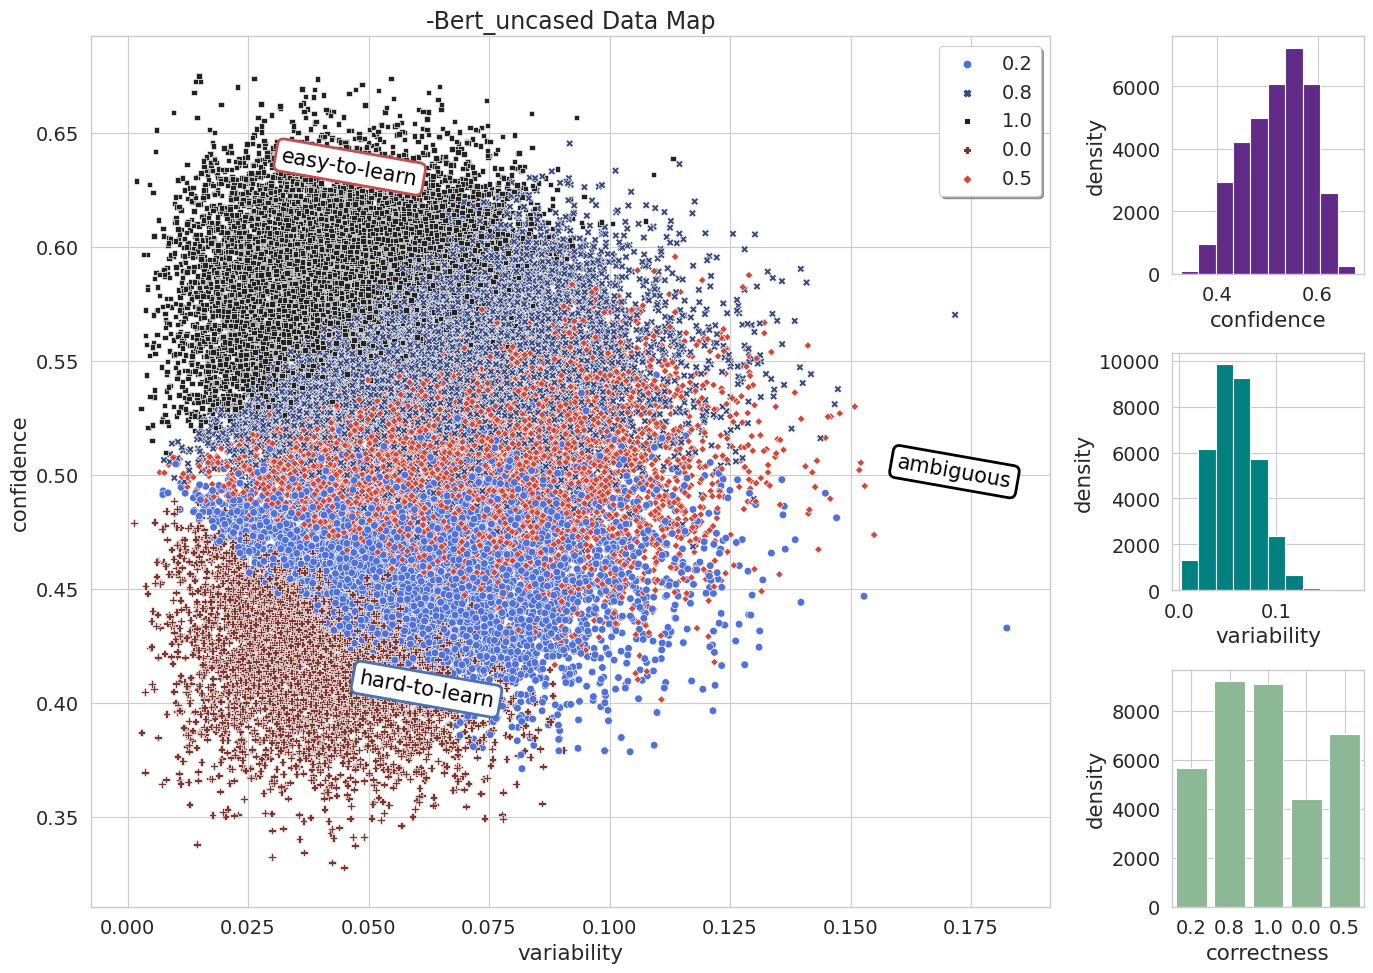

In [36]:
training_dynamics  = read_training_dynamics(args.model_dir, strip_last=False, burn_out=args.burn_out)
total_epochs = len(list(training_dynamics.values())[0]["logits"])
if args.burn_out > total_epochs:
  args.burn_out = total_epochs
  logger.info(f"Total epochs found: {args.burn_out}")
train_dy_metrics, _ = compute_train_dy_metrics(training_dynamics, args)
burn_out_str = f"_{args.burn_out}" if args.burn_out > total_epochs else ""
train_dy_filename = os.path.join(args.model_dir, f"td_metrics{burn_out_str}.jsonl")
train_dy_metrics.to_json(train_dy_filename,
                          orient='records',
                          lines=True)
logger.info(f"Metrics based on Training Dynamics written to {train_dy_filename}")

if args.filter:
  assert args.filtering_output_dir
  if not os.path.exists(args.filtering_output_dir):
    os.makedirs(args.filtering_output_dir)
  assert args.metric
  write_filtered_data(args, train_dy_metrics)

if args.plot:
  assert args.plots_dir
  if not os.path.exists(args.plots_dir):
    os.makedirs(args.plots_dir)
  plot_data_map(train_dy_metrics, args.plots_dir, show_hist=True, model=args.model)